In [151]:
import pybamm
import matplotlib.pyplot as plt
import pandas as pd
import os
current_directory = os.getcwd()

parameter_values = pybamm.ParameterValues("Chen2020")
options = {"thermal": "lumped", "lithium plating": "irreversible","SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true","loss of active material": "stress-driven","particle mechanics":"swelling only"}
parameter_values = pybamm.ParameterValues("Chen2020")
model = pybamm.lithium_ion.SPM(options=options)

In [152]:
#thermal parameters update
parameter_values.update({"Negative electrode OCP entropic change [V.K-1]": -0.0002,
                         "Positive electrode OCP entropic change [V.K-1]": -0.0004,
                         "Contact resistance [Ohm]": 0.001,
                         "Total heat transfer coefficient [W.m-2.K-1]": 10.0,
                         "Cell cooling surface area [m2]": 0.00531,
                         "Cell volume [m3]": 2.42e-05,
                         "Cell thermal expansion coefficient [m.K-1]": 1.1e-06,})

In [153]:
#sei parameters update
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-12*0.002})
# parameter_values.update({"Ratio of lithium moles to SEI moles": 1.0*2})
# parameter_values.update({"Inner SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
#parameter_values.update({"Outer SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
# parameter_values.update({"SEI resistivity [Ohm.m]": 200000.0*0.1})
parameter_values.update({"EC diffusivity [m2.s-1]": 2e-18*0+2.5e-22*4})
# parameter_values.update({"EC initial concentration in electrolyte [mol.m-3]": 4541.0*1})
# parameter_values.update({"SEI growth activation energy [J.mol-1]": 38000.0*0})

In [154]:
def graphite_volume_change_Ai2020(sto, c_s_max):
    """
    Graphite particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change

In [155]:
def volume_change_Ai2020(sto, c_s_max):
    """
    Particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] > Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] > Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    omega = pybamm.Parameter("Positive electrode partial molar volume [m3.mol-1]")
    t_change = omega * c_s_max * sto
    return t_change

In [156]:
# LAM parameters update

parameter_values.update({"Positive electrode LAM constant proportional term [s-1]": 0.01/3600,
                         "Negative electrode LAM constant proportional term [s-1]": 0.02/3600,
                         
                         "Positive electrode LAM constant exponential term": 2.0*1.1,
                         "Negative electrode critical stress [Pa]": 60000000.0*1,
                         "Negative electrode LAM constant exponential term": 2.0*1.1,
                         "Positive electrode critical stress [Pa]": 375000000.0*1,
                         "Positive electrode partial molar volume [m3.mol-1]": 1.25e-05,
                         "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
                         "Negative electrode Young's modulus [Pa]": 15000000000.0,
                         "Negative electrode Poisson's ratio": 0.3,
                         "Positive electrode Poisson's ratio": 0.2,
                         "Positive electrode Young's modulus [Pa]": 375000000000.0,
                         "Negative electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Positive electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Negative electrode volume change": graphite_volume_change_Ai2020,
                         "Positive electrode volume change": volume_change_Ai2020,}, check_already_exists=False)

#parameter_values.update({"Positive electrode LAM constant exponential term": 2.0*1.1})
#parameter_values.update({"Negative electrode critical stress [Pa]": 60000000.0*0.0009})
#parameter_values.update({"Negative electrode LAM constant exponential term": 2.0*1.1})

#parameter_values.update({"Positive electrode critical stress [Pa]": 375000000.0*0.00001})




In [157]:
def plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_e

In [158]:
#Plating paremeters update
parameter_values.update({"Typical plated lithium concentration [mol.m-3]": 1000.0,
                        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
                        "Exchange-current density for plating [A.m-2]"
                        "": plating_exchange_current_density_OKane2020,
                        "Lithium plating kinetic rate constant [m.s-1]": 1e-09*0.001,
                        "Lithium plating transfer coefficient": 0.65,
                        "Initial plated lithium concentration [mol.m-3]": 0.0,}, check_already_exists=False)


In [169]:
from itertools import product


temp_list = [20, 25, 40]
crate_list = [0.3, 0.5, 0.7]
soc_list = [100]
dod_list = [60, 70, 90]

all_cases = list(product(temp_list, crate_list, soc_list, dod_list))

df = pd.DataFrame(all_cases,columns = ["Temperature", "C_rate", "SoC", "DoD"])
df.insert(0, "Case", range(1, len(df)+1))
df.to_csv(f"{current_directory}/ageingresults/Cases_for_ageing.csv", index=False)

In [160]:
df

,Case,Temperature,C_rate,SoC,DoD
0,1,20,0.3,0,60
1,2,20,0.3,0,70
2,3,20,0.3,0,90
3,4,20,0.3,50,60
4,5,20,0.3,50,70
...,...,...,...,...,...
76,77,40,0.7,50,70
77,78,40,0.7,50,90
78,79,40,0.7,100,60
79,80,40,0.7,100,70


2024-07-03 21:12:29.550 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [00:59<00:00, 18.47it/s]


Took 663.382 ms


2024-07-03 21:13:32.616 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:08<00:00, 16.00it/s]


Took 790.202 ms


2024-07-03 21:14:46.122 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:17<00:00, 14.06it/s]


Took 1.019 s


2024-07-03 21:16:09.123 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:03<00:00, 17.23it/s]


Took 628.368 ms


2024-07-03 21:17:16.397 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [00:58<00:00, 18.85it/s]


Took 660.565 ms


2024-07-03 21:18:18.951 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:02<00:00, 17.40it/s]


Took 758.099 ms


2024-07-03 21:19:25.750 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:09<00:00, 15.81it/s]


Took 688.821 ms


2024-07-03 21:20:40.082 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [00:54<00:00, 20.26it/s]


Took 593.519 ms


2024-07-03 21:21:37.850 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:06<00:00, 16.36it/s]


Took 710.372 ms


2024-07-03 21:22:48.662 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Step time must be at least 1.000 ns
Cycling: 100%|██████████| 1095/1095 [01:10<00:00, 15.61it/s]


Took 874.108 ms


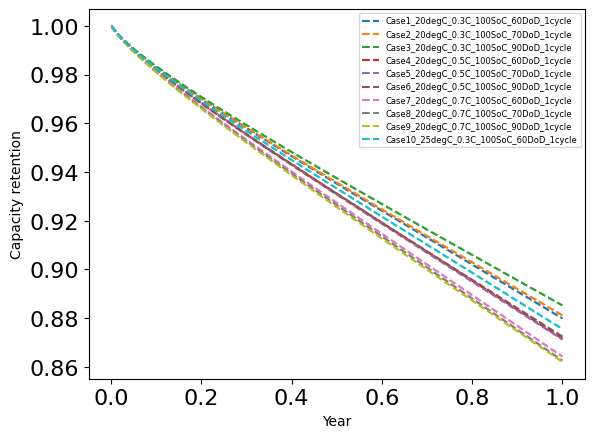

In [171]:
atol = 1e-3
rtol = 1e-3
dt_max = 1000
cycles_per_day = 1
days_per_year = 365
years_for_sim = 1
termination_capacity = 60
time_per_cycle = 24/cycles_per_day #in hours
soc_upper_cutoff = 1
soc_lower_cutoff = 0
max_dod = soc_upper_cutoff - soc_lower_cutoff
crate_ref = 0.2
period_charge_discharge = 2
period_rest = 120
safe_solver = pybamm.CasadiSolver(atol=atol, rtol=rtol, mode="safe", dt_max= dt_max)

df_conditions = {}
df_conditions = pd.DataFrame(df_conditions)
simcase_list = []
experiment_list = []
no_steps_list = []

for n in range(10):
    tempC_case = df["Temperature"][n]
    simcase = df["Case"][n]
    dod_case = df["DoD"][n]*0.01
    soc_case = df["SoC"][n]*0.01
    crate = df["C_rate"][n]
    
    parameter_values.update({"Ambient temperature [K]": 298.15 + tempC_case,
                            "Initial temperature [K]": 298.15 + tempC_case})

    t_soc0 = (1-soc_case)*60/crate_ref #time in minutes
    exp0 = pybamm.Experiment([(f"Charge at {crate_ref}C until 4.2V", "Hold at 4.2V until 50 mA", f"Discharge at {crate_ref}C for {t_soc0} minutes")])
    sim0 = pybamm.Simulation(model=model, parameter_values= parameter_values, experiment=exp0)
    sol0 = sim0.solve()

    model1 = model.set_initial_conditions_from(sol0)

    discharge_time = int(60/crate*dod_case) # in minutes
    charge_time = int(60/crate*dod_case) # in minutes
    rest_time = int(time_per_cycle*60) - discharge_time - charge_time

    discharge_string = f"Discharge at {crate}C for {discharge_time} min or until 2.5V ({period_charge_discharge} minute period)"
    charge_string = f"Charge at {crate}C for {charge_time} min or until 4.2V ({period_charge_discharge} minute period)"
    rest_string = f"Rest for {rest_time} min ({period_rest} minute period)"


    if (soc_case-dod_case) >= soc_lower_cutoff:
        list_of_steps_auto = list([discharge_string, charge_string, rest_string])
    elif (soc_case+dod_case)<= soc_upper_cutoff:
        list_of_steps_auto = list([charge_string, discharge_string, rest_string])
    elif soc_case ==0.5 and dod_case > soc_case:
        discharge_to_soc_time = int(60/crate*(dod_case-soc_case))
        updated_rest_time = rest_time - discharge_to_soc_time
        discharge_to_soc_string = f"Discharge at {crate}C for {discharge_to_soc_time} minutes ({period_charge_discharge} minute period)"
        updated_rest_string = f"Rest for {updated_rest_time} minutes ({period_rest}) minute period)"
        
        list_of_steps_auto = list([discharge_string, charge_string, updated_rest_string]) # discharge_to_soc_string,
        
    steps_total = len(list_of_steps_auto)
        
    simcase_list.append(f"Case {simcase}: {tempC_case}degC, {soc_case*100}%SoC, {crate}C, {dod_case*100}%DoD, {cycles_per_day}cycles")
    no_steps_list.append(steps_total)
    experiment_list.append(list_of_steps_auto)
    exp1 = pybamm.Experiment(list_of_steps_auto*cycles_per_day*days_per_year*years_for_sim, termination=f"{termination_capacity}% capacity")
    sim1 = pybamm.Simulation(model=model1, parameter_values=parameter_values, experiment=exp1, solver=safe_solver)
    sol1 = sim1.solve(showprogress=True, save_at_cycles=50)
    print("Took", sol1.solve_time)
    
    Q1 = sim1.solution.summary_variables["Capacity [A.h]"]
    cycle1 = sim1.solution.summary_variables["Cycle number"]
    df2 = {}
    df2 = pd.DataFrame(df2)
    df2["Days"] =cycle1/(steps_total*cycles_per_day)
    df2.to_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")

    plt.plot(cycle1/(steps_total*cycles_per_day)/days_per_year,Q1/Q1[0],"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
    plt.legend(fontsize=6)

plt.xlabel("Year")
plt.ylabel("Capacity retention")
plt.xticks(fontsize =16)
plt.yticks(fontsize = 16)
plt.show()

df_conditions["simcase"] = simcase_list
df_conditions["Experiment"] = experiment_list
df_conditions["n_steps"] = no_steps_list

df_conditions.to_csv(f"{current_directory}/ageingresults/experiments.csv")



In [ ]:
# Q1 = sim1.solution.summary_variables["Capacity [A.h]"]
# cycle1 = sim1.solution.summary_variables["Cycle number"]
# df2 = {}
# df2 = pd.DataFrame(df2)
# df2["Days"] =cycle1/(steps_total*cycles_per_day)
# df2.to_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")

# plt.plot(cycle1/(steps_total*cycles_per_day)/days_per_year,Q1/Q1[0],"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
# plt.legend(fontsize=6)

# plt.xlabel("Year")
# plt.ylabel("Capacity retention")
# plt.xticks(fontsize =16)
# plt.yticks(fontsize = 16)
# plt.show()

# df_conditions["simcase"] = simcase_list
# df_conditions["Experiment"] = experiment_list
# df_conditions["n_steps"] = no_steps_list

#df_conditions.to_csv(f"{current_directory}/ageingresults/experiments.csv")